<h3>Get Stock Data</h3>

In [47]:
from pandas_datareader.data import DataReader 
from datetime import date
import yfinance as yf


currencies = ["BTC-USD","ETH-USD","TTE.PA"] 
start_date = '2021-01-01'
end_date = str(date.today())

yf.pdr_override()
df = DataReader(
    'BTC-USD',
    start=start_date,
    end=end_date
)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782


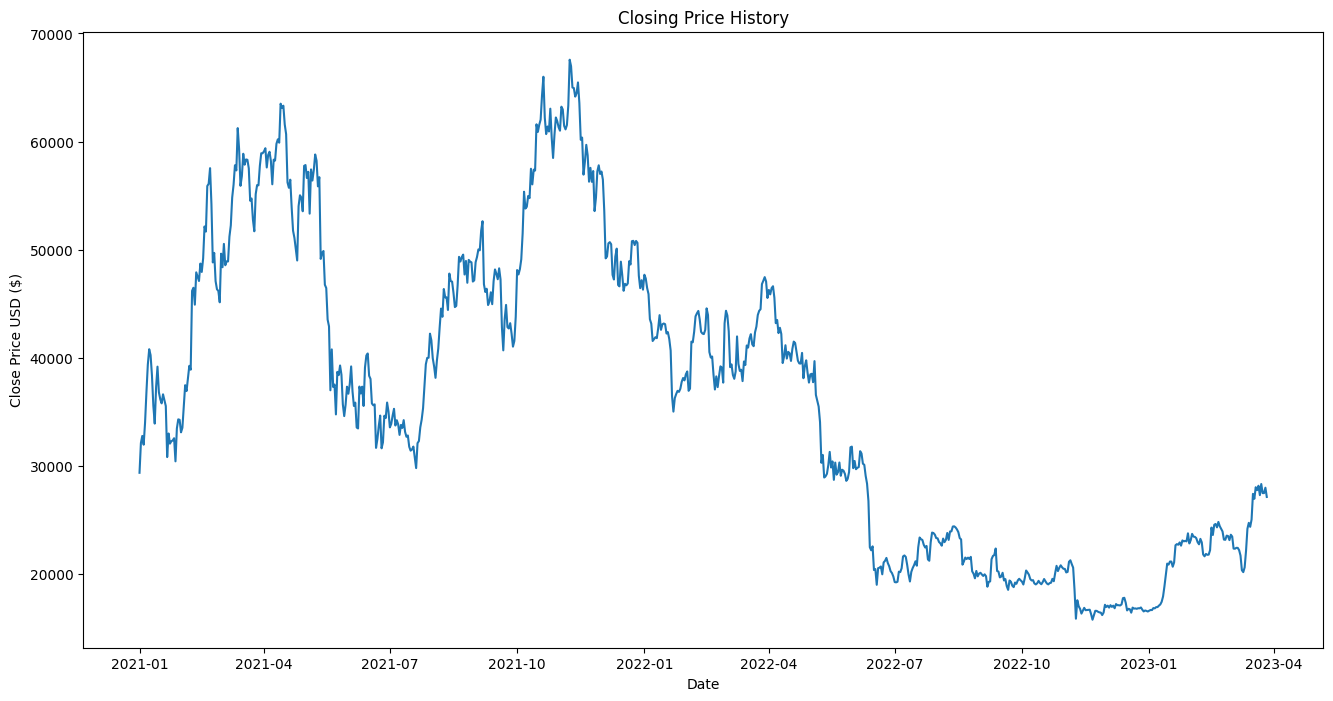

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(df['Close'])
plt.ylabel('Close Price USD ($)')
plt.xlabel('Date')
plt.title('Closing Price History')
plt.show()

In [49]:
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np

data = df.filter(['Close']).values
training_data_len = math.ceil(0.8*len(data))

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len:]

x_train , y_train = [] , []

# lag_len = 60
# for i in range(lag_len, len(train_data)):
#     x_train.append(train_data[i-60:i,0])
#     y_train.append(train_data[i,0])


# x_test , y_test = [] , []

# for i in range(lag_len, len(test_data)):
#     x_test.append(test_data[i-60:i,0])
#     y_test.append(test_data[i,0])

# x_train , y_train = np.array(x_train) , np.array(y_train)
# x_test , y_test = np.array(x_test) , np.array(y_test)

# x_train = np.reshape(x_train , (x_train.shape[0],x_train.shape[1],1))
# x_test = np.reshape(x_test , (x_test.shape[0],x_test.shape[1],1))

<h1>Neural Network</h1>

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
# plt.style.use()

<h3>Hyperparameters and other variable definition</h3>

In [51]:
# defines the device in which we would like to keep the tensor
device = torch.device("cpu") #change for cuda if gnu version available

# Used to enable training analysis through TensorBoard
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

In [53]:
def create_dataset(dataset , lag :int):
    x , y = [] , []
    for i in range(lag, len(dataset)):
        x.append(dataset[i-lag:i,0])
        y.append(dataset[i,0])
    return torch.Tensor(x),torch.Tensor(y)

In [54]:
lag = 60
x_train , y_train = create_dataset(train_data,lag)
x_test , y_test = create_dataset(test_data,lag)

In [63]:
class NaiveLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = x_train.shape[1],
            hidden_size = 126,
            num_layers = 2,
            batch_first=True
        )
        self.linear = nn.Linear(126,1)
    
    def forward(self,x):
        x,_ = self.lstm(x)
        x = self.linear(x)
        return x

In [65]:
import torch.utils.data as data
import torch.optim as optim 

model = NaiveLSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(x_train,y_train),shuffle=True,batch_size=10)

n_epoch = 5000
for epoch in range(n_epoch):
    model.train()
    for X_batch , y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(x_train)
        train_rmse = np.sqrt(loss_fn(y_pred,y_train))
        y_pred = model(x_test)
        test_rmse = np.sqrt(loss_fn(y_pred,y_test))
    print(f'Epoch {epoch} : train RMSE {train_rmse} , test RMSE {test_rmse}')

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([593])) that is different to the input size (torch.Size([593, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Epoch 0 : train RMSE 0.26933321356773376 , test RMSE 0.18067346513271332
Epoch 100 : train RMSE 0.30101272463798523 , test RMSE 0.09612381458282471


Definine NN

Training finished. Final loss: nan


ValueError: x and y must have same first dimension, but have shapes (100,) and (20,)

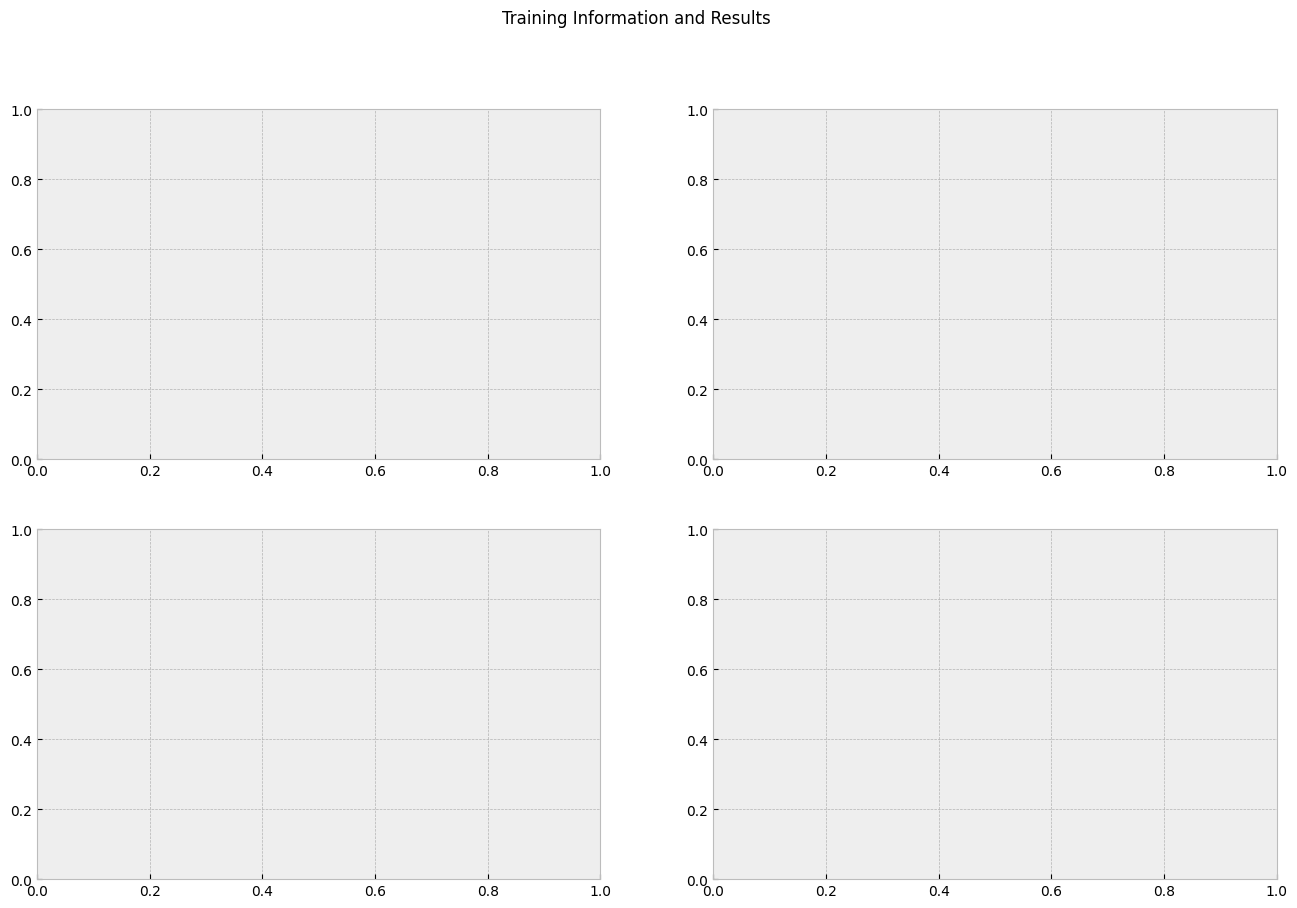

In [ ]:

print(f"Training finished. Final loss: {loss:.6f}")
a = np.linspace(1,n_epochs,n_epochs//100).astype(int)

fig , axs = plt.subplots(2,2 , figsize=(16,10))
fig.suptitle("Training Information and Results")

ax1 = axs[0,0]
ax1.plot(a,history)
ax1.set(xlabel="Epoch" , ylabel="Loss",title='Loss Function')

final_result = y_train[700:] - y_pred
ax2 = axs[0,1]
ax2.plot(x[700:],final_result.detach().numpy())
ax2.set(ylabel='Difference',xlabel='x')
ax2.set_title('Différence between original and predicted values')

ax3 = axs[1,1]
ax3.plot(x[0:700],y_train[0:700],x[700:],y_pred.detach().numpy(),'r')
ax3.set(title='Final trained result',ylabel='y_pred',xlabel='x')

ax4 = axs[1,0]
ax4.plot(x[0:700],y_train[0:700],'b',x[700:],y_train[700:],'r')
ax4.set(title='Initial values',ylabel='y_train',xlabel='x')